In [ ]:
%reload_ext autoreload
%autoreload

In [ ]:
import pandas as pd
import geopandas as gpd
import shapely
import nomad.io.base as loader
import numpy as np
from functools import partial
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import nomad.stop_detection.utils as utils
import nomad.stop_detection.hdbscan as HDBSCAN
import nomad.stop_detection.lachesis as LACHESIS
import nomad.stop_detection.ta_dbscan as TADBSCAN
import nomad.stop_detection.grid_based as GRID_BASED # for oracle visits
import nomad.visit_attribution as visits
import nomad.filters as filters
from nomad.contact_estimation import overlapping_visits, compute_visitation_errors, compute_precision_recall_f1

In [ ]:
metrics_df = pd.read_csv('metrics_df.csv')

In [ ]:
metrics_df

,Unnamed: 0,missed_fraction,merged_fraction,split_fraction,precision,recall,f1,user,algorithm,user_idx
0,0,0.873984,0.000000,0.008130,1.000000,0.096230,0.175566,gracious_babbage,oracle,75
1,1,0.898374,0.008130,0.016260,0.997956,0.096875,0.176606,gracious_babbage,lachesis,75
2,2,0.902439,0.008130,0.020325,0.998047,0.101389,0.184078,gracious_babbage,ta-dbscan,75
3,3,0.873984,0.093496,0.004065,0.965103,0.123462,0.218919,gracious_babbage,hdbscan,75
4,4,0.686916,0.000000,0.009346,0.999258,0.401042,0.572369,happy_ritchie,oracle,80
...,...,...,...,...,...,...,...,...,...,...
795,795,0.878641,0.101942,0.000000,0.959308,0.101736,0.183963,kind_wescoff,hdbscan,105
796,796,0.726496,0.000000,0.012821,0.999496,0.294891,0.455416,mystifying_wozniak,oracle,119
797,797,0.773504,0.017094,0.029915,0.998510,0.265873,0.419931,mystifying_wozniak,lachesis,119
798,798,0.777778,0.034188,0.029915,0.998064,0.281349,0.438958,mystifying_wozniak,ta-dbscan,119


In [ ]:
# metrics_df.groupby(['algorithm'])[['missed_fraction','merged_fraction','split_fraction','precision','recall','f1']].mean()

bootstrapping=True
if bootstrapping:
    output = []
    agg_keys = ['missed_fraction','merged_fraction','split_fraction','precision','recall','f1']
    agg_dict = {key:'median' for key in agg_keys}
    for _ in range(100):
        output += [metrics_df.sample(len(metrics_df), replace=True).groupby('algorithm', as_index=False).agg(agg_dict)]
    metrics_bootstrap_df = pd.concat(output)

In [ ]:
metrics_bootstrap_df

,algorithm,missed_fraction,merged_fraction,split_fraction,precision,recall,f1
0,hdbscan,0.782924,0.153454,0.004878,0.976839,0.240947,0.386094
1,lachesis,0.847836,0.009709,0.026457,0.998055,0.156126,0.269888
2,oracle,0.806931,0.000000,0.014019,0.999476,0.177083,0.300860
3,ta-dbscan,0.858974,0.021930,0.022727,0.997131,0.178671,0.303058
0,hdbscan,0.794355,0.154324,0.008333,0.975484,0.259648,0.410189
...,...,...,...,...,...,...,...
3,ta-dbscan,0.852679,0.023810,0.027027,0.997453,0.186756,0.314549
0,hdbscan,0.794355,0.151786,0.005051,0.975223,0.243006,0.388840
1,lachesis,0.819224,0.012931,0.026316,0.997849,0.183953,0.310491
2,oracle,0.799573,0.000000,0.016001,0.999373,0.192411,0.322712


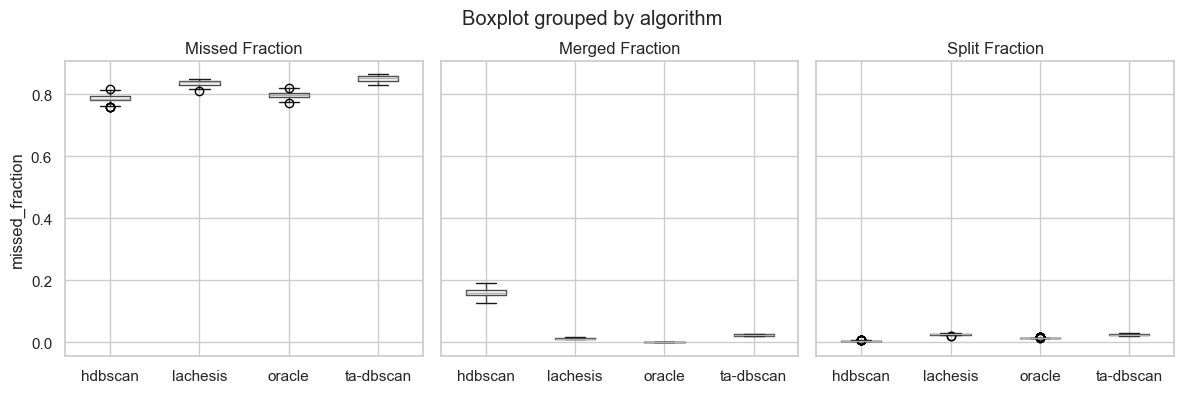

In [ ]:
# first group: the three error‐fractions, share y‐axis [0,1]
frac_metrics = ["missed_fraction", "merged_fraction", "split_fraction"]
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
for ax, metric in zip(axes, frac_metrics):
    metrics_bootstrap_df.boxplot(column=metric, by="algorithm", ax=ax)
    ax.set_title(metric.replace("_", " ").title())
    ax.set_xlabel("")           # drop the “by …” label
    ax.set_ylabel(metric if ax is axes[0] else "")  # only leftmost gets ylabel
    ax.grid(True)
fig.tight_layout()
fig.subplots_adjust(top=0.85)
plt.show()

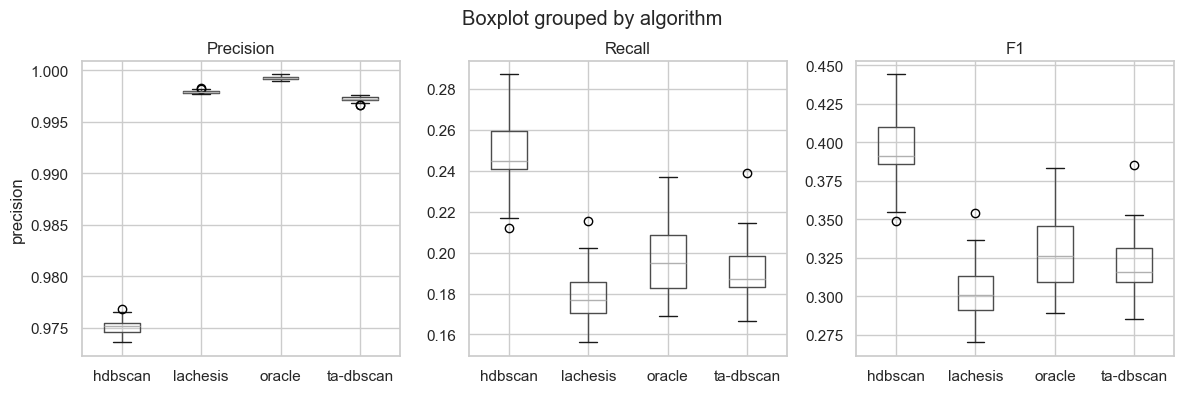

In [ ]:
prf_metrics = ["precision", "recall", "f1"]
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, metric in zip(axes, prf_metrics):
    metrics_bootstrap_df.boxplot(column=metric, by="algorithm", ax=ax)
    ax.set_title(metric.upper() if metric=="f1" else metric.title())
    ax.set_xlabel("")
    ax.set_ylabel(metric if ax is axes[0] else "")
    ax.grid(True)
fig.tight_layout()
fig.subplots_adjust(top=0.85)
plt.show()

In [ ]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


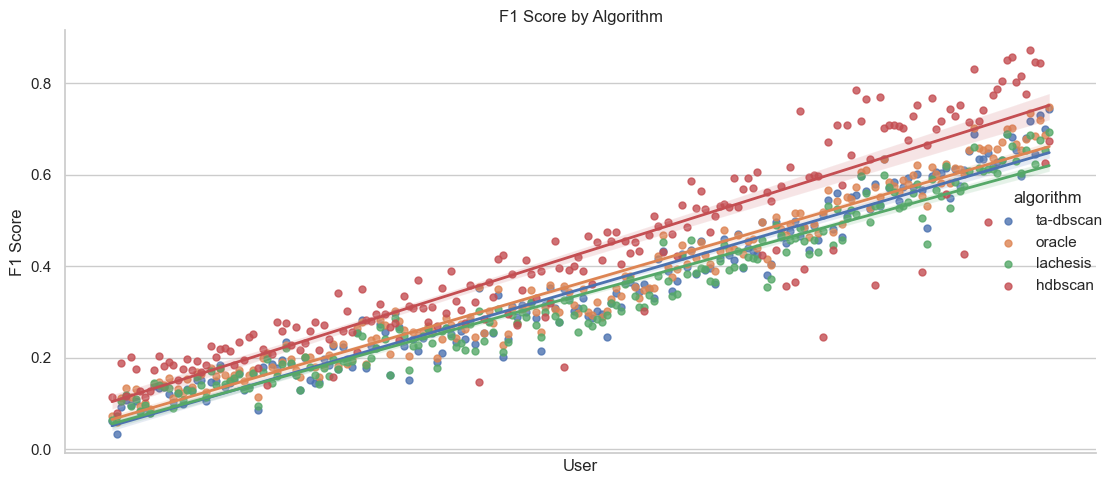

In [ ]:
# TO DO: plot to compare algorithm with oracle, x-axis is users sorted by completeness_df.q_stat. y-axis = f1. or recall. 
# Alternatively, q_stat vs F1 scatter plot.

sorted_uids = completeness_df.sort_values('q_stat')['uid'].tolist()
# filtered_metrics = metrics_df[metrics_df['algorithm'].isin(['oracle', 'hdbscan'])].copy()
filtered_metrics = metrics_df.copy()
filtered_metrics = filtered_metrics.merge(completeness_df, left_on='user', right_on='uid', how='left')

filtered_metrics['uid'] = pd.Categorical(filtered_metrics['uid'], categories=sorted_uids, ordered=True)
filtered_metrics = filtered_metrics.sort_values('uid')

# Assign numeric index based on sorted uid
filtered_metrics['user_idx'] = filtered_metrics['uid'].cat.codes

sns.lmplot(
    data=filtered_metrics,
    x='user_idx',
    y='f1',
    hue='algorithm',
    scatter_kws={'s': 25},
    line_kws={'linewidth': 2},
    aspect=2
)

plt.xticks([], [])  # Hide x-axis user labels
plt.xlabel('User')      # Remove label if desired
plt.ylabel('F1 Score')
plt.title('F1 Score by Algorithm')
plt.tight_layout()
plt.show()